In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.visualization import display_loss
from scripts.models.pytorch.train import train

from scripts.models.random_forest.random_forest import train_random_forest

from NIDS_attacks.substitut import attack_substitut
from NIDS_attacks.fgsm import attack_fgsm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="test_substitut",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

c:\Users\valen\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-27 08:20:53,903 - INFO - Logger initialized for 'test_substitut_20251127_082053'


In [3]:
dataset = UNSWNB15(
    dataset_size="small",
    logger=logger
).optimize_memory().encode()
import numpy as np
neg_cols = [col for col in dataset.data.columns if (dataset.data[col] < 0).any()]
neg_cols

2025-11-27 08:21:37,338 - INFO - Downloading dataset: mrwellsdavid/unsw-nb15
2025-11-27 08:21:44,102 - INFO - Loaded UNSW-NB15_1.csv with shape: (700000, 46)
2025-11-27 08:21:44,107 - INFO - DataFrame shape: (700000, 46)
2025-11-27 08:21:44,109 - INFO - Initial dimensions: 700,000 rows x 46 columns = 32,200,000 cells
2025-11-27 08:21:48,805 - INFO - ============================================================
2025-11-27 08:21:48,806 - INFO - Preprocessing completed successfully
2025-11-27 08:21:48,807 - INFO - Final dimensions: 640,658 rows x 46 columns
2025-11-27 08:21:48,808 - INFO - Total rows removed: 59,342 (8.48%)
2025-11-27 08:21:48,808 - INFO - data retention rate: 91.52%
2025-11-27 08:21:48,809 - INFO - ============================================================
2025-11-27 08:21:48,963 - INFO - Optimizing memory usage of the dataset...
2025-11-27 08:21:48,968 - INFO - Initial memory usage: 229.73 MB
2025-11-27 08:21:49,141 - INFO - Optimized memory usage: 136.86 MB
2025-11-27

[]

In [6]:
X_train, X_test, y_train, y_test = dataset.subset(size=400*1000, multi_class=False).split(
    one_hot=True,
    test_size=0.2,
    apply_smote=True
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

2025-11-27 08:22:40,750 - INFO - Subsetting dataset to size: 400000...
2025-11-27 08:22:40,766 - INFO - Class distribution before subsetting:
2025-11-27 08:22:40,770 - INFO -   Class 0: 626380 samples
2025-11-27 08:22:40,774 - INFO -   Class 1: 14278 samples
2025-11-27 08:22:40,860 - INFO - Subsetted dataset to size: 214278
2025-11-27 08:22:41,268 - INFO - Splitting dataset into training and testing sets...
2025-11-27 08:22:41,626 - INFO - Class distribution before SMOTE:
2025-11-27 08:22:44,713 - INFO - Applied SMOTE to balance the training set.
2025-11-27 08:22:44,738 - INFO - Class distribution after SMOTE:
2025-11-27 08:22:44,742 - INFO -   Class 0.0: 159998 samples
2025-11-27 08:22:44,746 - INFO -   Class 1.0: 159998 samples


Train set shape: (319996, 45)
Test set shape: (42856, 45)


Initialisation des données


In [7]:
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=10,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)

if cv_scores != None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-27 08:22:50,528 - INFO - Training Random Forest with cross-validation using train_random_forest...


Evaluation of the Random Forest Before attack

2025-11-27 08:23:10,386 - INFO - Running analysis for scikit-learn model: RandomForest before adversarial attack


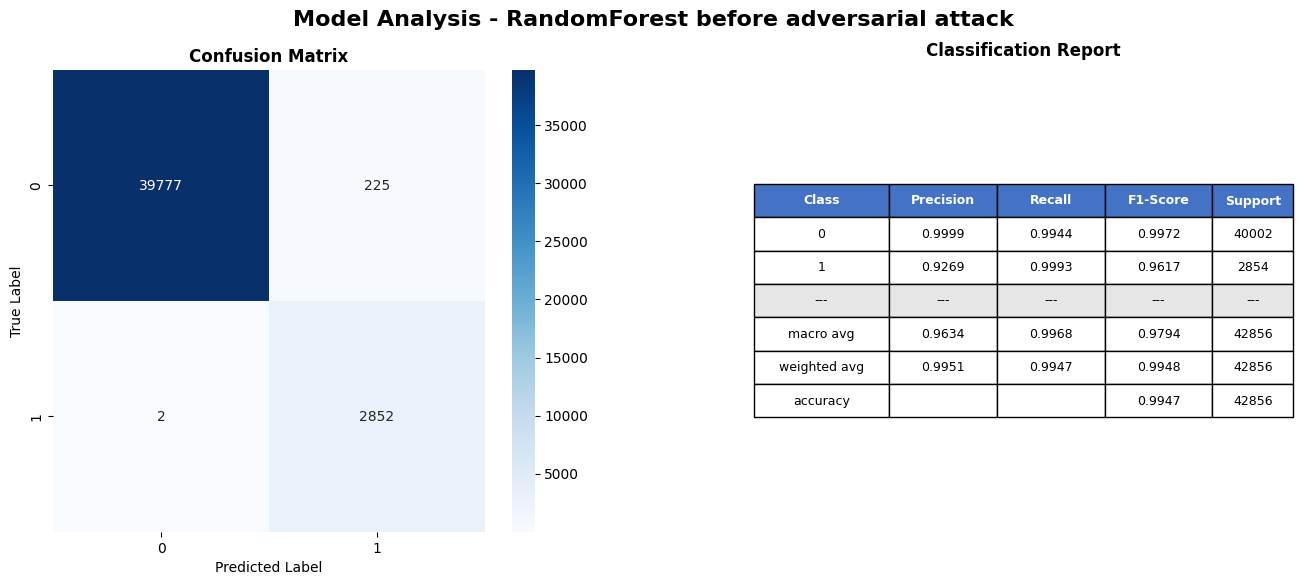

In [8]:
# Evaluate model
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="RandomForest before adversarial attack",
    root_dir=root_dir,
    plot=True
)

Generation of the substitut for the attack

2025-11-27 08:23:13,607 - INFO - Running analysis for scikit-learn model: RandomForest Substitut
Loss: 0.0001, Val Loss: 0.0018, LR: 0.010000: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]
2025-11-27 08:24:57,203 - INFO - Plotting loss curve...
2025-11-27 08:24:58,555 - INFO - Loss curve saved as c:\msys64\home\valen\TDpython\AdversarialNIDS\results\loss_plots/Substitute_MLPRandomForest Substitut_100_loss.png


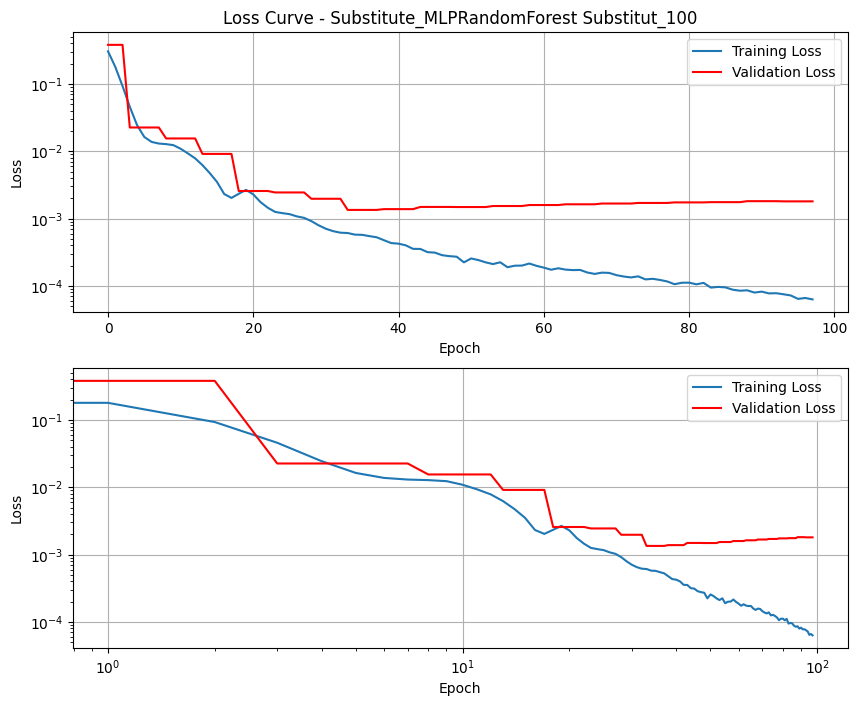

2025-11-27 08:24:58,906 - INFO - Running analysis for PyTorch model: Substitute_MLPRandomForest Substitut_100 on device: cpu


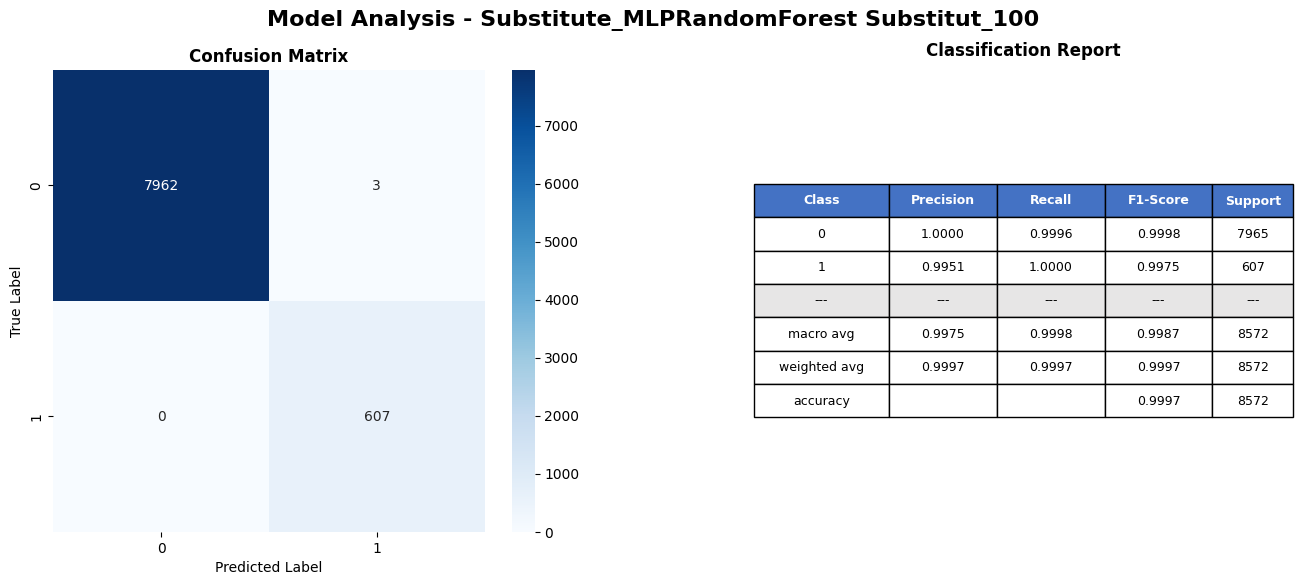

In [9]:
sub, cm, cr = attack_substitut(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    root_dir=root_dir,
    logger=lm.logger,
    model_name="RandomForest Substitut",
    plot_analysis=True,
    plot_loss=True,
    save_fig=True,
    device=device
)

Attack

In [ ]:
from NIDS_attacks.bounds_constrains import apply_bounds_constraints

x_adv = torch.FloatTensor(X_test).clone().detach().requires_grad_(True).to(device)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

print("Target class for the attack:", target.shape)

sub = sub.to(device)
sub.eval()
epsilon = 1

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=sub,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred.argmax(axis=1))

list_x_adv = [initial_x_adv]
for iter in range(100):
    new_x_adv, loss, pred = attack_fgsm(
        model=sub,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=epsilon
    )

    # Recompute derived features
    #x_adv_rf = compute_features_batch(new_x_adv,dico = dico_encoded)

    # Apply bounds constraints
    x_adv = apply_bounds_constraints(
        x_adv=new_x_adv,
        x_original=x_adv,
        modifiable_indices=dataset.MODIFIABLE_FEATURES,
        min_vals=torch.tensor(X_train,dtype=torch.float32).min(axis=0).values.to(device),
        max_vals=torch.tensor(X_train,dtype=torch.float32).max(axis=0).values.to(device)
    )

    # Check if attack is successful
    if pred.argmax(axis=1).sum() == 0:
        # new_x_adv = apply_integer_constraints(
        #     x_adv=new_x_adv,
        #     integer_indices=dataset.INTEGER_FEATURES
        # )

        # Final evaluation without perturbation
        x_adv, loss, pred = attack_fgsm(
            model=sub,
            criterion=criterion,
            x_val=x_adv,
            target=target,
            eps=0.0
        )

        # Check if attack is successful after applying constraints
        if pred.argmax(axis=1).sum() == 0:
            print(f"Successful adversarial example found at iteration {iter+1}")
            break


print(f"Adversarial input after {iter+1} iterations:", pred.argmax(axis=1))
diff_adv = x_adv - initial_x_adv
print("Magnitude of perturbation:")
print(torch.norm(diff_adv, dim=1).cpu().numpy())


Target class for the attack: torch.Size([42856])
Initial prediction on adversarial input: [0 0 1 ... 0 0 0]
Successful adversarial example found at iteration 20
Adversarial input after 20 iterations: [0 0 0 ... 0 0 0]
Magnitude of perturbation:
[49.48334  54.56189  55.903645 ... 55.15072  58.438    42.042847]
tensor([[5.3528e+04, 1.1391e+04, 9.6000e+01,  ..., 1.6000e+01, 1.0000e+00,
         1.0000e+00],
        [2.0279e+04, 4.5600e+04, 1.0000e+02,  ..., 1.0000e+00, 1.0000e+00,
         5.0000e+00],
        [6.6360e+03, 8.4060e+03, 9.4000e+01,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.1009e+04, 1.4529e+04, 9.4000e+01,  ..., 1.7000e+01, 1.0000e+00,
         1.0000e+00],
        [4.2954e+04, 4.5600e+04, 1.0000e+02,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [4.1249e+04, 4.5800e+03, 9.9000e+01,  ..., 1.5000e+01, 1.0000e+00,
         3.0000e+00]])


2025-11-26 23:12:16,125 - INFO - Running analysis for PyTorch model: Substitute Model on device: cpu


OSError: [Errno 28] No space left on device

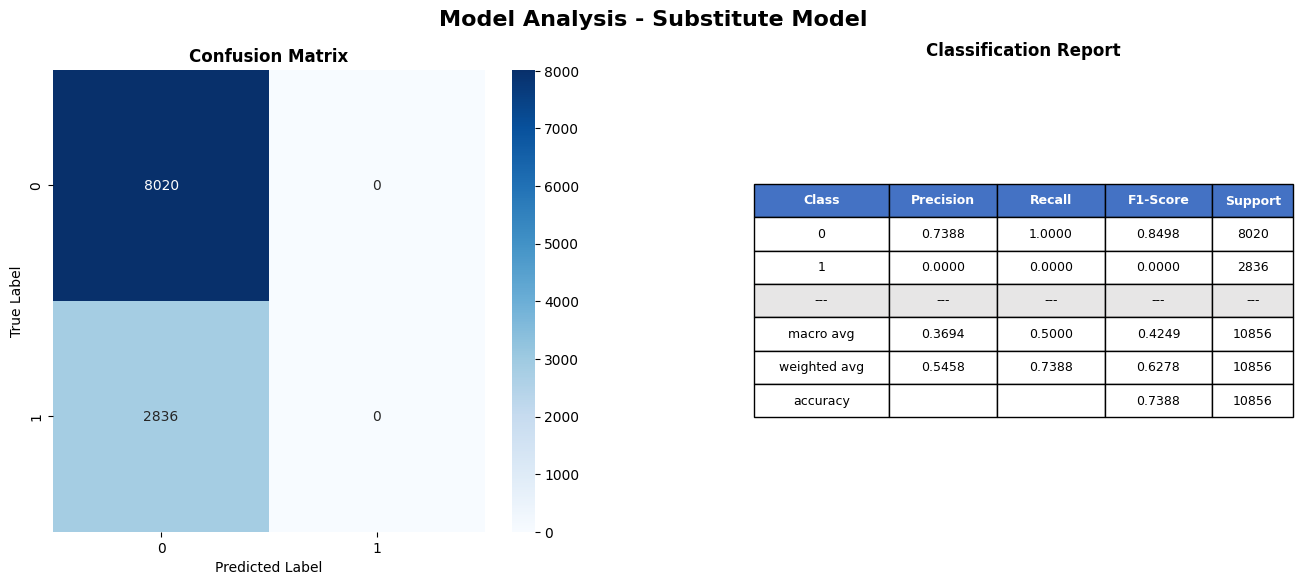

In [10]:
cm_rf, cr = perform_model_analysis(
    model=sub,
    X_test=x_adv,
    y_test=y_test,
    logger=logger,
    title="Substitute Model",
    root_dir=root_dir,
    plot=True
)

2025-11-26 23:12:26,255 - INFO - Running analysis for scikit-learn model: Random Forest


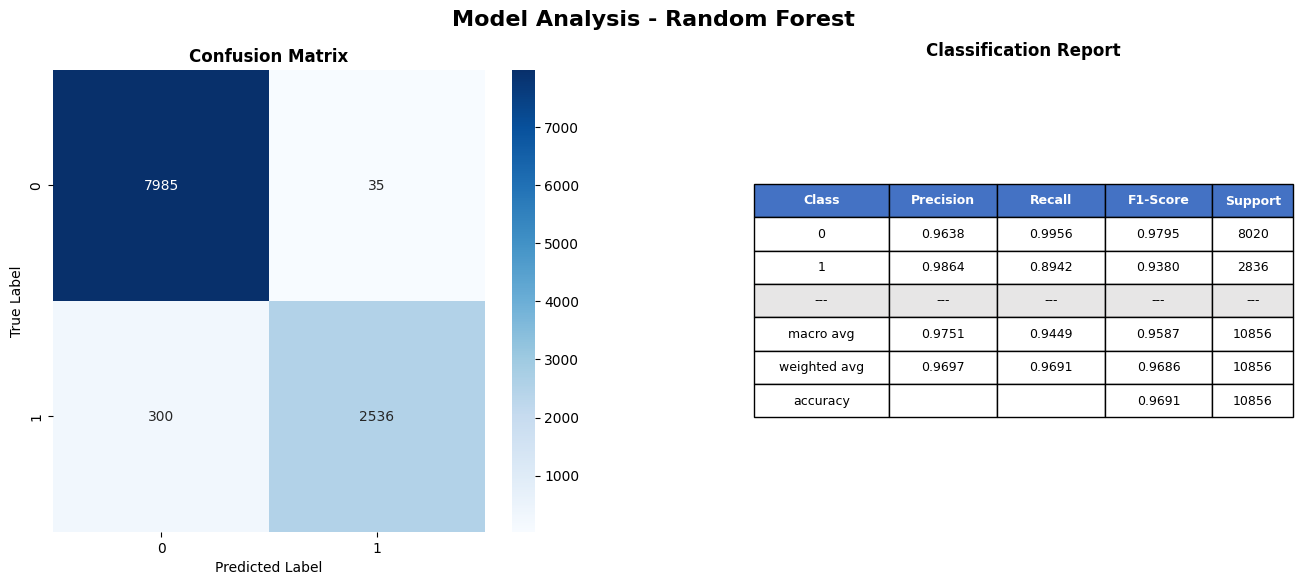

In [11]:
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=x_adv.cpu().numpy(),
    y_test=y_test,
    logger=logger,
    title="Random Forest",
    root_dir=root_dir,
    plot=True
)

In [47]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test_rob, y_train, y_test_rob = dataset.subset(size=400*1000, multi_class=False).split(
    one_hot=True,
    test_size=0.2,
    apply_smote=True
)
X_train_rob = np.concatenate([X_train, x_adv.cpu().numpy()], axis=0)
y_train_rob = np.concatenate([y_train, y_test], axis=0)

2025-11-26 23:47:30,627 - INFO - Subsetting dataset to size: 400000...
2025-11-26 23:47:30,632 - INFO - Class distribution before subsetting:
2025-11-26 23:47:30,635 - INFO -   Class 0: 40000 samples
2025-11-26 23:47:30,637 - INFO -   Class 1: 14278 samples
2025-11-26 23:47:30,643 - INFO - Subsetted dataset to size: 54278
2025-11-26 23:47:30,706 - INFO - Splitting dataset into training and testing sets...
2025-11-26 23:47:30,822 - INFO - Class distribution before SMOTE:
2025-11-26 23:47:31,489 - INFO - Applied SMOTE to balance the training set.
2025-11-26 23:47:31,491 - INFO - Class distribution after SMOTE:
2025-11-26 23:47:31,492 - INFO -   Class 0.0: 31985 samples
2025-11-26 23:47:31,493 - INFO -   Class 1.0: 31985 samples


In [48]:
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model_robuste, cv_scores = train_random_forest(
    X_train_rob,
    y_train_rob,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)

if cv_scores != None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-26 23:47:34,680 - INFO - Training Random Forest with cross-validation using train_random_forest...


2025-11-26 23:47:54,775 - INFO - Running analysis for scikit-learn model: Random Forest


OSError: [Errno 28] No space left on device

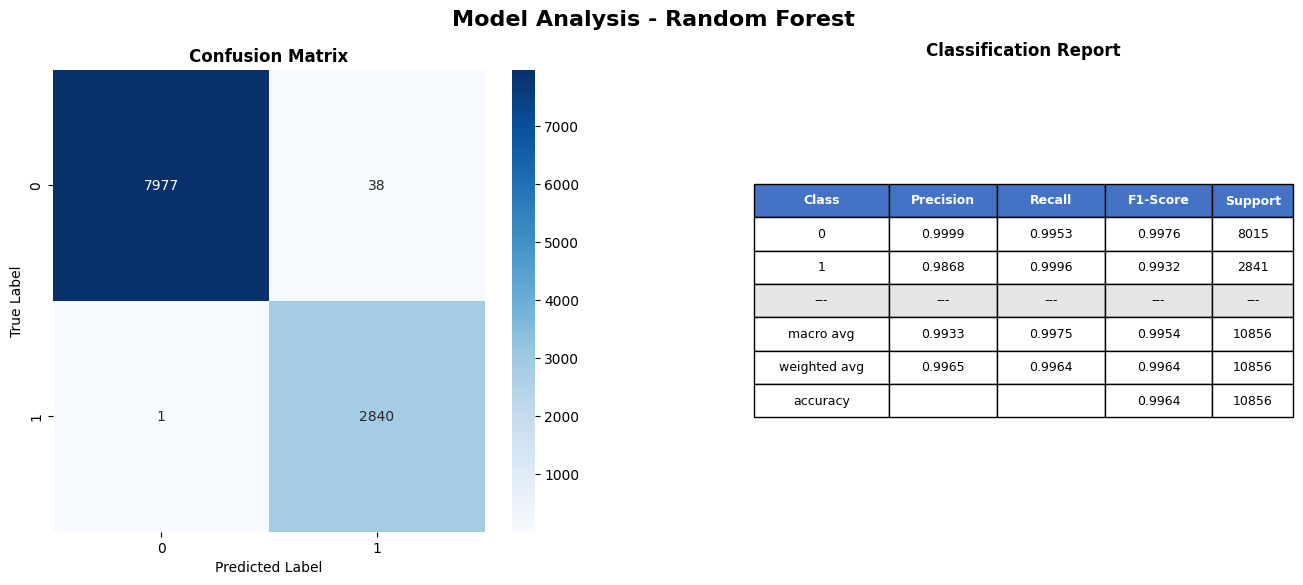

In [49]:
cm_rf, cr = perform_model_analysis(
    model=rf_model_robuste,
    X_test=X_test_rob,
    y_test=y_test_rob,
    logger=logger,
    title="Random Forest",
    root_dir=root_dir,
    plot=True
)

2025-11-26 23:48:12,098 - INFO - Running analysis for scikit-learn model: RandomForest Substitut
Loss: 0.0000, Val Loss: 0.0001, LR: 0.010000: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]
2025-11-26 23:48:43,069 - INFO - Plotting loss curve...
2025-11-26 23:48:44,792 - INFO - Loss curve saved as c:\msys64\home\valen\TDpython\AdversarialNIDS\results\loss_plots/Substitute_MLPRandomForest Substitut_100_loss.png


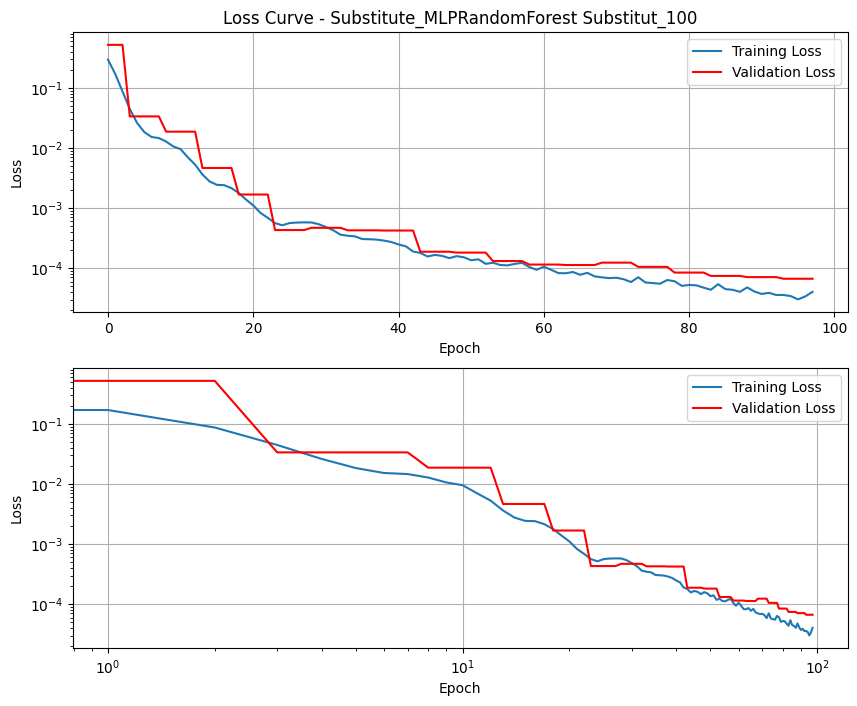

2025-11-26 23:48:45,427 - INFO - Running analysis for PyTorch model: Substitute_MLPRandomForest Substitut_100 on device: cpu


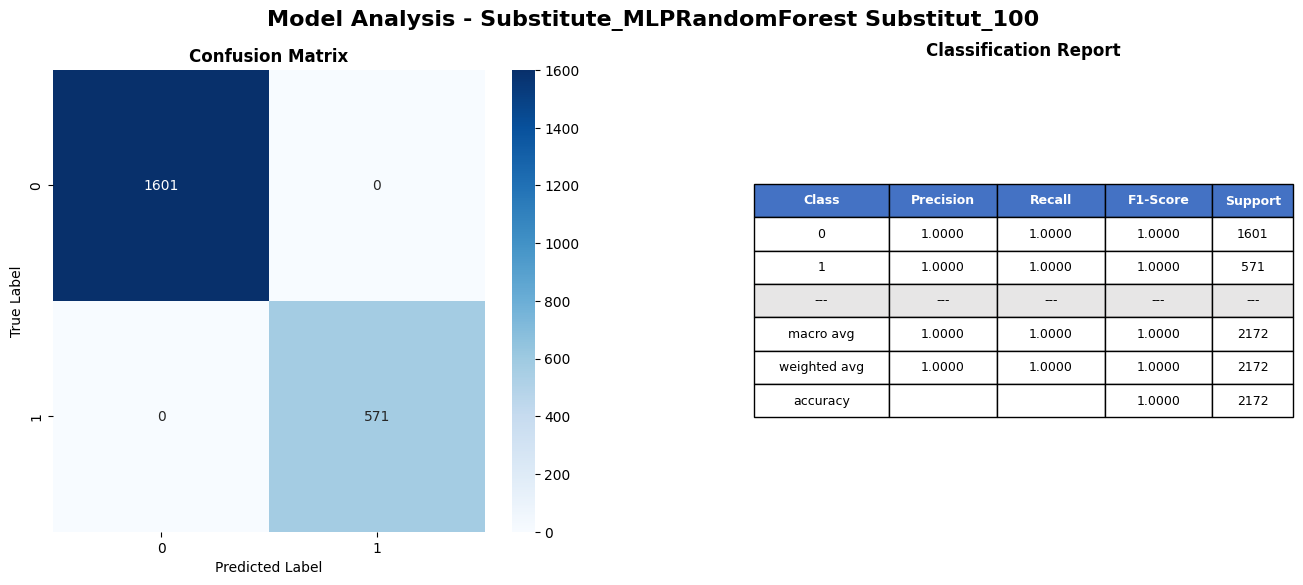

In [50]:
sub, cm, cr = attack_substitut(
    model=rf_model,
    X_test=X_test_rob,
    y_test=y_test_rob,
    root_dir=root_dir,
    logger=lm.logger,
    model_name="RandomForest Substitut",
    plot_analysis=True,
    plot_loss=True,
    save_fig=True,
    device=device
)

In [51]:
from NIDS_attacks.bounds_constrains import apply_bounds_constraints

x_adv = torch.FloatTensor(X_test_rob).clone().detach().requires_grad_(True).to(device)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

print("Target class for the attack:", target.shape)

sub = sub.to(device)
sub.eval()
epsilon = 1

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=sub,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred.argmax(axis=1))

list_x_adv = [initial_x_adv]
for iter in range(100):
    new_x_adv, loss, pred = attack_fgsm(
        model=sub,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=epsilon
    )

    # Recompute derived features
    #x_adv_rf = compute_features_batch(new_x_adv,dico = dico_encoded)

    # Apply bounds constraints
    x_adv = apply_bounds_constraints(
        x_adv=new_x_adv,
        x_original=x_adv,
        modifiable_indices=dataset.MODIFIABLE_FEATURES,
        min_vals=torch.tensor(X_train,dtype=torch.float32).min(axis=0).values.to(device),
        max_vals=torch.tensor(X_train,dtype=torch.float32).max(axis=0).values.to(device)
    )

    # Check if attack is successful
    if pred.argmax(axis=1).sum() == 0:
        # new_x_adv = apply_integer_constraints(
        #     x_adv=new_x_adv,
        #     integer_indices=dataset.INTEGER_FEATURES
        # )

        # Final evaluation without perturbation
        x_adv, loss, pred = attack_fgsm(
            model=sub,
            criterion=criterion,
            x_val=x_adv,
            target=target,
            eps=0.0
        )

        # Check if attack is successful after applying constraints
        if pred.argmax(axis=1).sum() == 0:
            print(f"Successful adversarial example found at iteration {iter+1}")
            break


print(f"Adversarial input after {iter+1} iterations:", pred.argmax(axis=1))
diff_adv = x_adv - initial_x_adv
print("Magnitude of perturbation:")
print(torch.norm(diff_adv, dim=1).cpu().numpy())

Target class for the attack: torch.Size([10856])
Initial prediction on adversarial input: [0 0 0 ... 0 1 1]
Successful adversarial example found at iteration 4
Adversarial input after 4 iterations: [0 0 0 ... 0 0 0]
Magnitude of perturbation:
[14.       14.759699 14.026839 ... 14.793533 14.12557  13.143614]


2025-11-26 23:49:12,277 - INFO - Running analysis for PyTorch model: Substitute Model on device: cpu


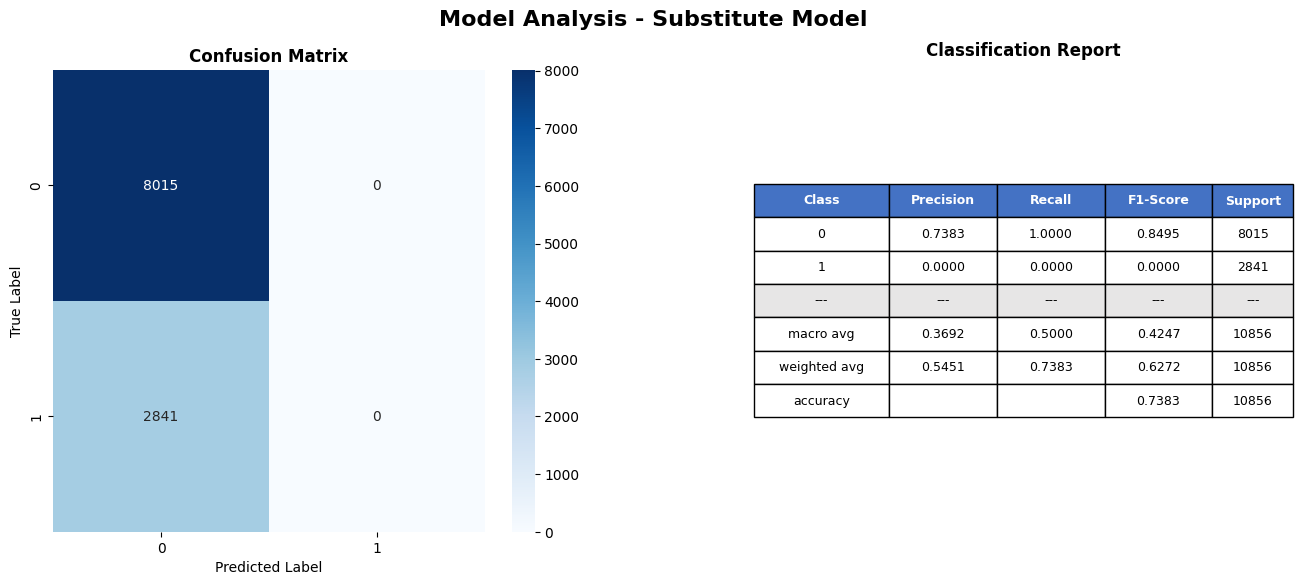

In [52]:
cm_rf, cr = perform_model_analysis(
    model=sub,
    X_test=x_adv,
    y_test=y_test_rob,
    logger=logger,
    title="Substitute Model",
    root_dir=root_dir,
    plot=True
)

2025-11-26 23:49:18,530 - INFO - Running analysis for scikit-learn model: Random Forest


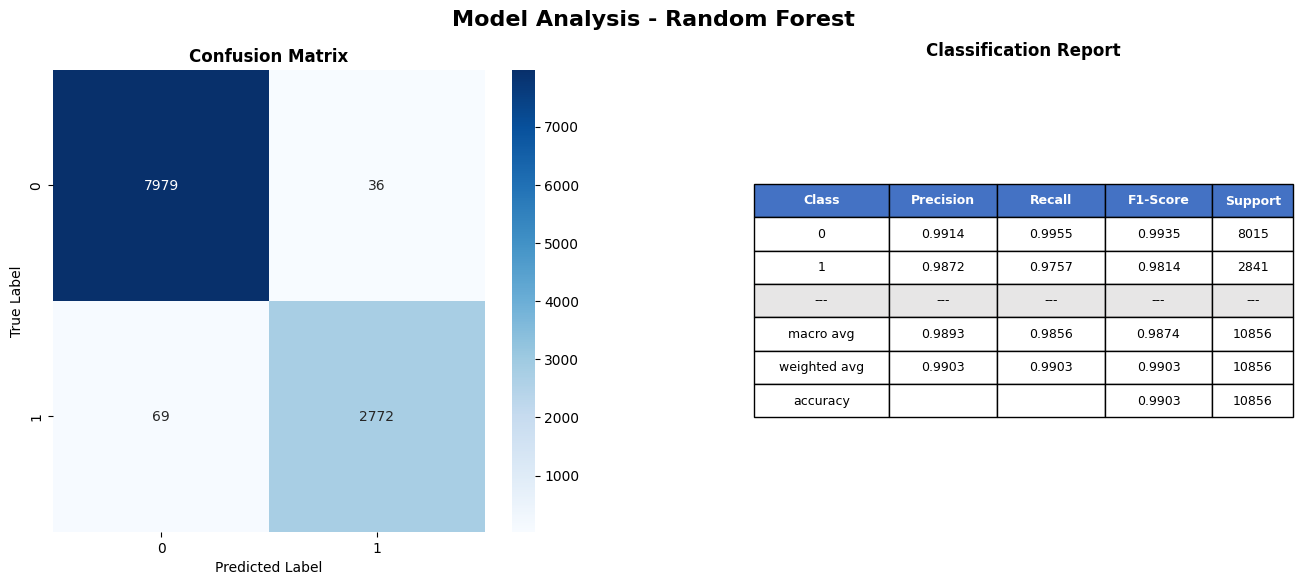

In [53]:
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=x_adv.cpu().numpy(),
    y_test=y_test_rob,
    logger=logger,
    title="Random Forest",
    root_dir=root_dir,
    plot=True
)